# COMP-767 : Reinforcement Learning - Assigment 1

## Bandits algorithm
I choosed option (a) that is based on the paper Best-arm identification algorithms for multi-armed bandits in the fixed confidence setting,
Kevin Jamieson and Robert Nowak, CISS, 2014
https://people.eecs.berkeley.edu/˜kjamieson/resources/bestArmSurvey.pdf. All the code for this part is in the file bandits.py.

(a) Summarize the main results in the paper

(b) Reproduce the results in Figure 1

In [1]:
%load_ext autoreload
%autoreload 2

import bandits
import mdp

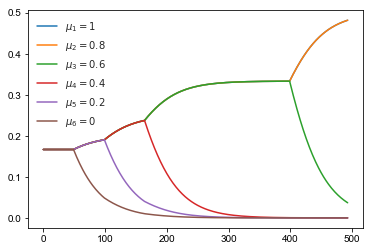

In [2]:
bandits.trial_bandit(bandits.ActionEliminationBanditTrial, n_trials=1, n_time_steps=500)

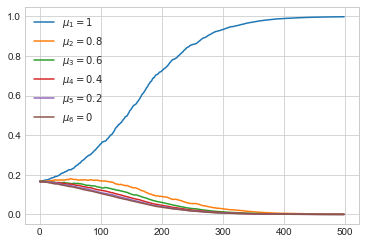

In [3]:
bandits.trial_bandit(bandits.UCBBanditTrial, n_trials=5, n_time_steps=500)

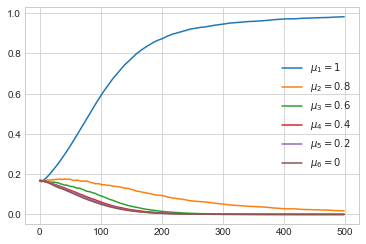

In [4]:
bandits.trial_bandit(bandits.LUCBBanditTrial, n_trials=5, n_time_steps=500)

(c) Perform the same empirical comparison on the bandit problem provided in the Sutton & Barto book (which we discussed in class). Do not forget to average your results over multiple independent runs.

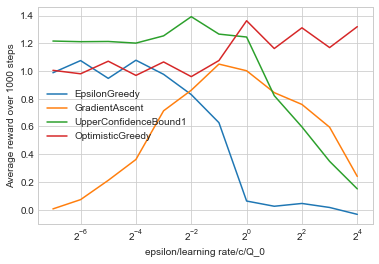

In [5]:
bandits.plot_parameter_study(nb_test = 100, nb_step = 100, k=10)

(d) Discuss in a short paragraph a concrete application in which you think regret optimization would be more useful than best arm identification

# Markov Decision Processes and dynamic programming
I choosed option (a)

In [6]:
mdp.hyper_parameter_testing(world_size=5, p_desired_direction=0.7, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  5
p_desired_direction :  0.7
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION
Policy found in 4 iterations, where each policy evaluation lasted for k = [81, 31, 21, 6]

V
 [[0.  6.6 8.1 9.5 0. ]
 [5.  6.1 7.1 8.2 9.5]
 [4.6 5.3 6.2 7.1 8.1]
 [4.1 4.6 5.3 6.2 7. ]
 [3.6 4.1 4.7 5.4 6. ]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 3.6435727051962012 , True :  3.5497275534205954
Bottom right. V : 6.028787227105289 , True :  6.06575717133129


MODIFIED POLICY ITERATION
Policy found in 5 iterations, where each policy evaluation lasted for k = [2, 2, 2, 2, 2]

V
 [[0.  6.5 8.  9.5 0. ]
 [4.6 5.8 7.  8.2 9.5]
 [3.8 4.9 5.9 7.  8.1]
 [2.9 3.7 4.9 5.9 6.8]
 [1.8 2.9 3.9 5.  5.8]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 1.8428573026888924 , True :  3.7223132200449736
Bottom right. V : 5.772750339641569 , True :  6.0480178996500005


VALUE ITERATION
Policy found in 29 iterations

V
 [[0.  6.6 8.1 9.5 0. ]
 [5.  6.1 7.1 8.2 9.5]

In [7]:
mdp.hyper_parameter_testing(world_size=5, p_desired_direction=0.9, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  5
p_desired_direction :  0.9
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION
Policy found in 5 iterations, where each policy evaluation lasted for k = [84, 20, 13, 8, 2]

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.5 6.2 7.  7.8 8.8]
 [5.  5.5 6.2 7.  7.8]
 [4.4 5.  5.6 6.2 6.9]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 4.443413699152674 , True :  4.473830886326101
Bottom right. V : 6.931096096796003 , True :  6.907842665009998


MODIFIED POLICY ITERATION
Policy found in 6 iterations, where each policy evaluation lasted for k = [2, 2, 2, 2, 2, 2]

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.5 6.2 7.  7.8 8.8]
 [4.9 5.5 6.2 7.  7.8]
 [4.3 4.9 5.5 6.2 6.9]]

PI
■→→→■
→→→→↑
→→→↑↑
↑→↑↑↑
→→→↑↑


Testing
Bottom left. V : 4.273341078299059 , True :  4.38969085669539
Bottom right. V : 6.928890539946193 , True :  6.900545601


VALUE ITERATION
Policy found in 19 iterations

V
 [[0.  7.6 8.8 9.9 0. ]
 [6.1 7.  7.8 8.8 9.9]
 [5.

In [8]:
mdp.hyper_parameter_testing(world_size=50, p_desired_direction=0.7, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  50
p_desired_direction :  0.7
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION
Policy found in 44 iterations, where each policy evaluation lasted for k = [74, 99, 71, 53, 39, 20, 18, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

V
 [[0.  0.9 0.8 ... 8.1 9.5 0. ]
 [0.9 0.8 0.7 ... 7.1 8.2 9.5]
 [0.8 0.7 0.6 ... 6.2 7.1 8.1]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

PI
■←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→■
↑←←←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑↑←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑↑←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑↑←←←←←←←←←←←↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑
↑↑↑↑↑↑←←←←←←←←←←↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑
↑↑↑↑↑↑↑←←←←←←←←↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑←←←←←←↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑←←←←↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑←↑↑↑↑

In [9]:
mdp.hyper_parameter_testing(world_size=50, p_desired_direction=0.9, gamma=0.9, epsilon=1e-5)

HYPER PARAMETERS
world_size :  50
p_desired_direction :  0.9
gamma :  0.9
epsilon :  1e-05


POLICY ITERATION
Policy found in 21 iterations, where each policy evaluation lasted for k = [78, 95, 60, 41, 26, 23, 20, 19, 17, 18, 22, 25, 20, 21, 1, 1, 1, 1, 1, 1, 1]

V
 [[0.  1.  0.9 ... 8.8 9.9 0. ]
 [1.  0.9 0.8 ... 7.8 8.8 9.9]
 [0.9 0.8 0.7 ... 7.  7.8 8.8]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]

PI
■←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→■
↑←←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑
↑↑←←←←←←←←←←←←←→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑
↑↑↑←←←←←←←←←←←↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑
↑↑↑↑←←←←←←←←←↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑
↑↑↑↑↑↑←←←←←←↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑
↑↑↑↑↑↑↑←←←←↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑←←↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→→→→→→→→→→→→→→→↑↑↑↑↑↑↑↑↑↑
↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑→→→→→→→